In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *

MODE = "SimulatedData"
DB_PATH = "Simulation/FSN_Data_5k.db"
CONFIG.ROOT_FOLDER = "Uva/LargeDataset/"
CONFIG.EXPERIMENT = [0, 0]

#  ---------- CONFIG Setting HERE ------------
# .1 Sampling parameters
CONFIG.STRATEGY = "MetaDiff"
CONFIG.PRESSURE = 10
CONFIG.WINDOW_SIZE = 2
CONFIG.WALKS_PER_NODE = 30
CONFIG.WALKS_LENGTH = 10
# .2 TF parameters
CONFIG.STEPS = 50000
CONFIG.EMBD_SIZE = 8
CONFIG.LOSS_FUNCTION = "NegativeSampling"  # or "NCE"
CONFIG.BATCH_SIZE = 256
CONFIG.NEGATIVE_SAMPLES = 512

updateCONFIG(False)

if MODE == "SimulatedData":
    EMBS_PATH = CONFIG.WORK_FOLDER[0]+CONFIG.WORK_FOLDER[1]+CONFIG.WORK_FOLDER[2]
#     EMBS_PATH = "UvA/MediumDataset/verMetaDiff_dirCOMBI_walks20_pressure30_1hopFraction0_/windowSize2/EMB32_batch64_TFsteps100000_ /"
#     EMBS_PATH = "Simulation_versionMetaDiff_directionCOMBI_walks30_pressure30_window3/TFsteps100000batch64_emb32/"
    embs = pd.read_pickle(EMBS_PATH+"Embeddings.pkl")
    print("Embeddings have been uploaded to memory!")
    with open(CONFIG.WORK_FOLDER[0] + CONFIG.WORK_FOLDER[1] + "skip_grams_cached.pkl", "rb") as file:
        skip_gr = pickle.load(file)
    d_truth = upload_JournalEntriesTruth(DB_PATH)
    d = upload_data(DB_PATH, limit=None)
    d = prepare_data(d)
    print("Supported information has been uploaded to memory!")
    
CONFIG.GLOBAL_FSN = FSN()
CONFIG.GLOBAL_FSN.build(d, left_title="FA_Name")
tr = TransformationBPs(CONFIG.GLOBAL_FSN.get_BP())

Config file has been updated!
Embeddings have been uploaded to memory!
Final shape of DataFrame is  (29239, 9)
Supported information has been uploaded to memory!


## Upload data

In [5]:
map_truth = dict(zip(d_truth.ID.values, d_truth.GroundTruth.values))
def countNext(df):
    c=df.groupby("Next").count()
    return pd.Series(dict(zip(list(c.T), c.T.values[0])))
cur_truth = pd.DataFrame(data=[[map_truth[pair[0]], map_truth[pair[1]]] for pair in tr.decode_pairs(skip_gr)], columns=["Current", "Next"])
final_df = cur_truth.groupby("Current").apply(countNext).reset_index()\
        .pivot(index='Current', columns='level_1', values=0).fillna(0)
del final_df.index.name
del final_df.columns.name
final_df

,Collections,Depreciation,Disbursement,Fixed Assets,Goods delivery,Payroll,Payroll Disbursement,Purchase,Sales 21 btw,Sales 6 btw,Sales tax
Collections,896256.0,0.0,102092.0,20692.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Depreciation,0.0,215380.0,7.0,111.0,562.0,250.0,0.0,72.0,281.0,277.0,0.0
Disbursement,102092.0,7.0,47924.0,60293.0,23.0,12.0,0.0,11.0,10.0,14.0,0.0
Fixed Assets,20692.0,111.0,60293.0,135550.0,436.0,201.0,0.0,60.0,214.0,229.0,0.0
Goods delivery,0.0,562.0,23.0,436.0,994438.0,935.0,0.0,448.0,1328.0,1228.0,0.0
Payroll,0.0,250.0,12.0,201.0,935.0,472186.0,0.0,136.0,24072.0,9814.0,0.0
Payroll Disbursement,0.0,0.0,0.0,0.0,0.0,0.0,91196.0,0.0,0.0,0.0,125810.0
Purchase,0.0,72.0,11.0,60.0,448.0,136.0,0.0,131640.0,155.0,166.0,0.0
Sales 21 btw,0.0,281.0,10.0,214.0,1328.0,24072.0,0.0,155.0,284698.0,207486.0,0.0
Sales 6 btw,0.0,277.0,14.0,229.0,1228.0,9814.0,0.0,166.0,207486.0,275748.0,0.0


# Heat map of sampled pairs as (Current GroundTruth, Context GroundTruth)

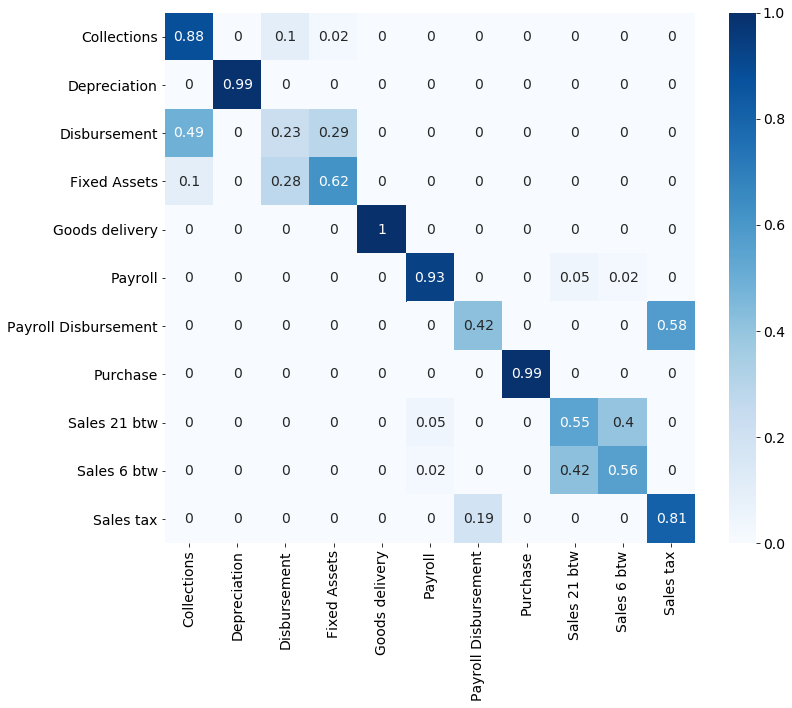

In [6]:
import seaborn as sns
set_font(14)
plt.figure(figsize=(12, 10))
sns.heatmap(final_df.apply(lambda x: round(x/x.sum(), 2), axis=1), cmap="Blues", annot=True, square=True) 
# plt.xticks(rotation=30)
plt.tight_layout()
# plt.savefig("img/SensitivityAnalysis/Middle_finWalk_winSize"+str(CONFIG.WINDOW_SIZE)\
#             +"_walks"+str(CONFIG.WALKS_PER_NODE)\
#             +"_length"+str(CONFIG.WALKS_LENGTH) \
#             +"_pressure"+str(CONFIG.PRESSURE)\
#             +"_hack"+str(CONFIG.HACK)+".jpg", dpi=140, pad_inches=0.01)

# Define the final objective

In [7]:
N_CL = 11
cl_labs = cl_Agglomerative(embs, N_CL)

First row of Data: 
 [-0.08358651 -0.36047786  0.3449657  -0.35008436 -0.30682731 -0.07144488
  0.47218627 -0.54708427]


In [14]:
all_metrics = evaluate_all(cl_labs, column_true="GroundTruth", postfix="N")
all_metrics

{'Adjusted Rand indexN': 0.9689005757547675,
 'Adjusted Mutual InformationN': 0.9674903269370271,
 'V-measureN': 0.9676365838954587,
 'Fowlkes-Mallows indexN': 0.9728680449210577}

In [8]:
local_titles = ["Sales 21 btw", "Sales 6 btw"]
all_metrics_local = evaluate_all(cl_labs[cl_labs.GroundTruth.isin(local_titles)], column_true="GroundTruth", postfix=", local")
all_metrics_local

{'ARI, local': 0.6429654343391349,
 'AMI, local': 0.5342893882615934,
 'V-M, local': 0.5346398931343191,
 'FMI, local': 0.821310918123511}

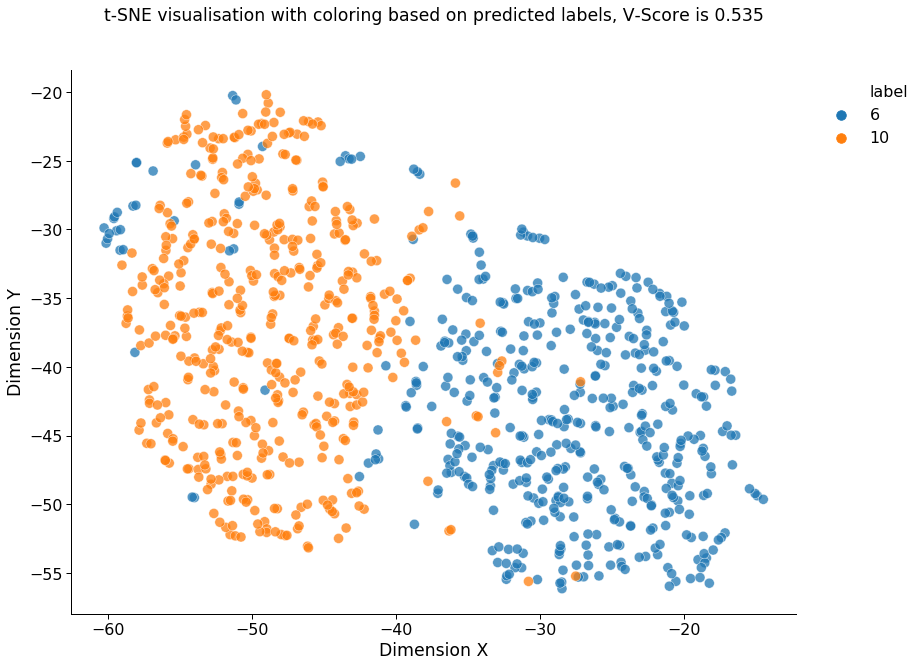

In [9]:
plot_tSNE(cl_labs[cl_labs.GroundTruth.isin(local_titles)], "label", title=None, context="paper_full")

## Parameters tuning

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *
CONFIG.ROOT_FOLDER = "UvA/LargeDataset/"
RESULT_FILE = "ResultsGOOD.xlsx"
tuning = pd.read_excel(CONFIG.ROOT_FOLDER + RESULT_FILE, index_col=0)
tuning.head(2)

,ExperimentNum,Strategy,Pressure,Walks per node,Walk length,Window size,Embedding size,Train steps,Batch size,ARI_N-1_global,...,ARI_N_global,AMI_N_global,V-M_N_global,FMI_N_global,ARI_N_local,AMI_N_local,V-M_N_local,FMI_N_local,Sampling time,TF time
0,"(0, 0)",MetaDiff,1,10,10,1,16,50000,256,0.997320,...,0.888348,0.952865,0.953068,0.909132,0.0,3.652318e-15,1.121326e-15,0.706793,0.0,0.0
1,"(0, 1)",MetaDiff,1,10,10,1,16,50000,256,0.998763,...,0.893565,0.956700,0.956887,0.913370,0.0,3.652318e-15,1.121326e-15,0.706793,0.0,0.0


In [20]:
def get_best_combinations(df, on="V-M", postfix=["_N_global", "_N-1_global", "_N_local", "_N-1_local"]):
    df_avg = add_average(df, on=on, postfix=postfix)
    return df_avg.groupby(["Strategy", "Pressure", "Walks per node", "Window size", "Embedding size", "Train steps"])\
        [["AVG_"+on]+[on+it for it in postfix]].mean()\
        .sort_values("AVG_"+on, ascending=False)

In [68]:
t = get_best_combinations(tuning, on="V-M").reset_index()
t[t["Train steps"]==50000].to_excel("ResultsTuning.xlsx")

## Sensitivity analysis

In [17]:
import numpy as np
CONFIG.ROOT_FOLDER = "UvA/LargeDataset/"
RESULT_FILE = "ResultsSensitivity.xlsx"
sens = pd.read_excel(CONFIG.ROOT_FOLDER + RESULT_FILE, index_col=0)
sens.head(2)

,ExperimentNum,Strategy,Pressure,Walks per node,Walk length,Window size,Embedding size,Train steps,Batch size,ARI_N-1_global,...,ARI_N_global,AMI_N_global,V-M_N_global,FMI_N_global,ARI_N_local,AMI_N_local,V-M_N_local,FMI_N_local,Sampling time,TF time
0,"(0, 0)",MetaDiff,1,30,10,2,8,50000,256,0.998737,...,0.998737,0.997053,0.997065,0.998948,0.001462,1.004857e-03,1.757791e-03,0.501225,0.970257,144.238722
1,"(0, 1)",MetaDiff,1,30,10,2,8,50000,256,0.998562,...,0.889691,0.956087,0.956276,0.910230,0.000000,3.652318e-15,1.121326e-15,0.706793,0.887150,157.718085


In [13]:
full_names_map = {"V-M": "V-Measure", "FMI": "Fowlkes-Mallows index", "AMI": "Adjusted Mutual Information", "ARI": "Adjusted Rand index"}
def add_average(df, on="V-M", postfix=["_N_global", "_N-1_global", "_N_local", "_N-1_local"], inplace=False):
    """
    Helper function to add a column with average values over the given metric
    :param df: input DataFrame
    :param on: Metric name
    :param postfix: List of postfixes to be used for calculation the average
    :param inplace: If False, return a copy of original DF with added column
    :return: None if inplace=True or DataFrame if inplace=False
    """
    avg_titles = [on + it for it in postfix]
    if inplace:
        df["AVG_" + on] = df.apply(lambda row: np.mean([row[title] for title in avg_titles]), axis=1)
        return
    else:
        df_local = df.copy()
        df_local["AVG_" + on] = df_local.apply(lambda row: np.mean([row[title] for title in avg_titles]), axis=1)
        return df_local
def sensPlot(df, mode="line", metric="V-M"):
    sns.set_context("paper", font_scale=2.3)
    fig_size = (6.4, 4.8)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    if mode=="line":
        sns.lineplot(x=df.columns[0], y="Final sscore", data=df, marker="s", markersize=7, err_style="band", err_kws={"alpha": 0.08}, ax=ax)
    else:
        sns.pointplot(x=df.columns[0], y="Final sscore", data=df, marker="s", markersize=7, ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(df.columns[0], labelpad=15)
    ax.set_ylabel(full_names_map[metric], labelpad=15)
    fig.savefig("img/SensitivityAnalysis/"+full_names_map[metric]+"_ErrorBar_for_" + df.columns[0] + "_" + mode+".png", bbox_inches="tight", dpi=140, pad_inches=0.05)
def get_required_metric(df, on="Pressure", metric="V-M"):
    df = add_average(df, on=metric)
    postfix=["AVG_"+metric]+[metric+it for it in ["_N_global", "_N-1_global", "_N_local", "_N-1_local"]]
    rename_map = dict(zip(postfix, ["Final score", "N clusters, global", "N-1 clusters, global", "N clusters, local", "N-1 clusters, local"]))
    nominal = {"Walks per node": 30, "Window size": 2, "Pressure": 10, "Embedding size": 8, "Train steps": 50000}
    group_key = list(nominal.keys())
    group_key.remove(on)
    to_plot = df\
                .groupby(group_key).get_group(tuple([nominal[it] for it in group_key]))[[on]+postfix]\
                .rename(rename_map, axis=1)
    return to_plot
def plotSensitivity(df, on="Pressure", metric="V-M", mode="final"):
    df = get_required_metric(df, on=on, metric=metric)
    sns.set_context("paper", font_scale=2.3)
    if mode=="final":
        fig_size = (6.4, 4.8)
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(111)
        sns.lineplot(x=df.columns[0], y="Final score", data=df, marker="s", markersize=7, err_style="band", err_kws={"alpha": 0.08}, ax=ax)
    elif mode=="all":
        df = df.set_index(on).stack().reset_index().rename({"level_1": "", 0: "score"}, axis=1)
        fig_size = (12, 8)
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(111)
#         df["alpha"] = np.where(df[""] == "Final score", 1.0, 0.5)
        sns.lineplot(x=df.columns[0], y="score", hue="", alpha=0.25, data=df[df[""]!="Final score"], marker="s", markersize=7, err_style="band", err_kws={"alpha": 0.05}, ax=ax)
        sns.lineplot(x=df.columns[0], y="score", hue="", alpha=1, lw=2, data=df[df[""]=="Final score"], marker="s", markersize=7, err_style="band", err_kws={"alpha": 0.1}, ax=ax)
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, markerscale=2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(df.columns[0], labelpad=15)
    ax.set_ylabel(full_names_map[metric], labelpad=15)
    fig.savefig("img/SensitivityAnalysis/"+full_names_map[metric]+"_ErrorBar_for_" + df.columns[0] + "_" + mode+".png", bbox_inches="tight", dpi=140, pad_inches=0.05)

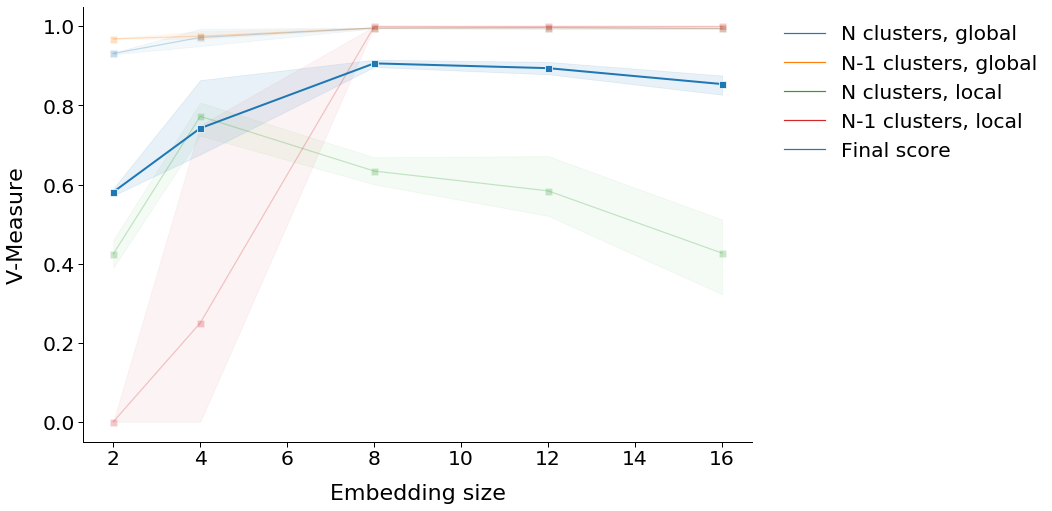

In [19]:
plotSensitivity(sens, metric="V-M", on="Embedding size", mode="all")